# Transformer-based model for long-time dissipative quantum dynamics

In [31]:
from qutip import *
import numpy as np
%pylab inline
from numpy import linalg as LA
import tensorflow
import keras
from sklearn.metrics import mean_squared_error

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/leherrera/anaconda3/envs/qutip+tf/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['squeeze', 'time', 'random', 'identity', 'axes', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import util
import random
#import keras_nlp
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

####
from models import HyperTrans
from models   import simple_model, Trans_encoder
from pos_encoding import positional_encoding, MapLayer
from pos_encoding import inp_transform ,mlp_relu , mlp_gelu

In [2]:
!python -c "import qutip; print(qutip.__version__)"
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

5.0.3.post1
2024-08-12 09:35:10.404064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2.12.0


In [11]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'Latin Modern Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
colors = cm.get_cmap('tab10', 2)

/tmp/ipykernel_378044/1690271028.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 2)


## Hamiltonian Model 

We test the transformer implementation on a time series representing the re duced density matrix dynamics of the spin-boson model

$\hat{H}=\epsilon \hat{\sigma}_z+\Delta \hat{\sigma}_x+\hat{\sigma}_z \sum_\alpha g_\alpha\left(b_\alpha^{\dagger}+b_\alpha\right)+\sum_\alpha \omega_\alpha b_\alpha^{\dagger} b_\alpha$

where $\hat{\sigma}_z=|+\rangle\langle+|-|-\rangle\langle-|$ and $\hat{\sigma}_x=|+\rangle\langle-|+|-\rangle\langle+|$ are the Pauli operators, $b_\alpha^{\dagger}\left(b_\alpha\right)$ is the bosonic creation (annihilation) operator of the $\alpha$ th mode with the frequency $\omega_\alpha, \epsilon$ is the energetic bias, $\Delta$ is the tunneling matrix element, and $g_\alpha$ are the subsystem-bath coupling coefficients.

In [71]:
# The system Hamiltonian:
eps = 0.0  # energy of the 2-level system
Del = 1.0  # tunnelling term
H_sys =  eps * sigmaz() +  Del * sigmax()

# Initial state of the system:
rho0 = basis(2,0) * basis(2,0).dag()

The description of the bath is completely determined by the spectral density $J(\omega)=$ $\pi \sum_\alpha g_\alpha^2 \delta\left(\omega_\alpha-\omega\right)$ which, in this work, is chosen to be of the Debye form (Ohmic spectral density with the Drude-Lorentz cut-off):

$J(\omega) = 2 \lambda \frac{\omega \omega_c}{\omega^2+\omega_c^2}$


The initial state of the total system is assumed to be a product state of the following form:

$\hat{ \rho}(0)  = \hat{ \rho}_s(0) \otimes \frac{e^{-\beta \hat{H}_B}}{Z_B} $

In [86]:
gamma = 1.1 # cut off frequency
lam = 0.25  # coupling strength
b = 0.9  # inverse temperature 
T = 1.0/b  # temperature

# System-bath coupling operator:
Q = sigmaz()

The evolution of the reduced density matrix $\hat{\rho}_s(t) = \text{Tr}_B[\hat{\rho(t)}]$ is done with Hierarchical equations of motion (HEOM) implemented in QuTiP (Physical Review Research 5.1 (2023): 013181)


In [87]:
from qutip.solver.heom import DrudeLorentzBath
# Number of the Matsubara expansion terms to retain:
Nk = 2
# Matsubara expansion:
bath = DrudeLorentzBath(Q, lam, gamma, T, Nk)

In [88]:
from qutip.solver.heom import HEOMSolver
from qutip import Options

max_depth = 30  # maximum hierarchy depth to retain
options = Options(nsteps=15000,rtol=1e-10,atol=1e-10)

delta, terminator = bath.terminator() #"Tanimura-terminator"
HL = liouvillian(H_sys) + terminator

# Construct solver:
solver = HEOMSolver(HL, bath, max_depth=max_depth, options=options)


/home/leherrera/anaconda3/envs/qutip+tf/lib/python3.9/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [89]:
# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()

# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):
P12p = basis(2,0) * basis(2,1).dag()

# Run the solver:
dt = 0.05          #dt
T = 20             #Total simulation time
ntime = int(T/dt)  #Number of time steps
tlist = np.arange(0,T,dt)
result = solver.run(rho0, tlist, e_ops={"11": P11p, "22": P22p, "12": P12p, "Sz": sigmaz()})



10.0%. Run time:   1.44s. Est. time left: 00:00:00:12
20.1%. Run time:   3.26s. Est. time left: 00:00:00:12
30.1%. Run time:   4.70s. Est. time left: 00:00:00:10
40.1%. Run time:   5.88s. Est. time left: 00:00:00:08
50.1%. Run time:   7.31s. Est. time left: 00:00:00:07
60.2%. Run time:   8.57s. Est. time left: 00:00:00:05
70.2%. Run time:   9.91s. Est. time left: 00:00:00:04
80.2%. Run time:  11.23s. Est. time left: 00:00:00:02
90.2%. Run time:  12.54s. Est. time left: 00:00:00:01
100.0%. Run time:  13.83s. Est. time left: 00:00:00:00
Total run time:  13.84s


Text(0.5, 1.0, ' $\\epsilon/\\Delta= 0$  $\\lambda/\\Delta=$0.25  $\\omega_c/\\Delta=$1.1 $\\beta \\Delta=$0.9')

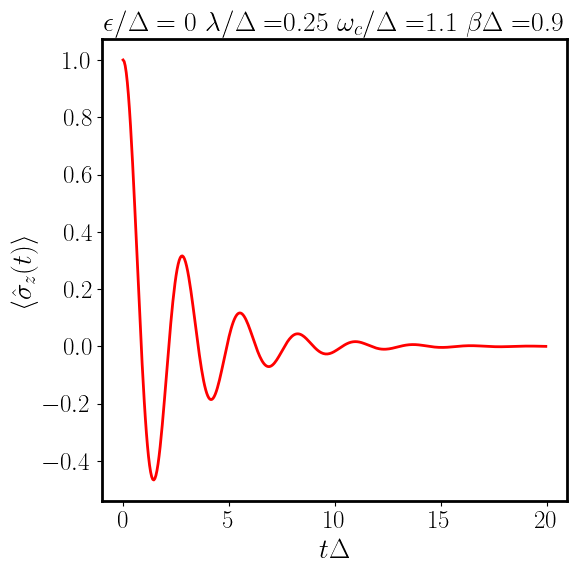

In [116]:
# Plot the results:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6,6))
#axes.plot(result.times, result.e_data["11"], 'b', linewidth=2, label="P11")
#axes.plot(result.times, result.e_data["22"], 'r', linewidth=2, label="P22")
axes.plot(result.times, np.real(result.e_data["Sz"]), 'r', linewidth=2, label="Sz")
axes.set_ylabel(r' $\langle \hat{\sigma}_z(t) \rangle$', fontsize=20)
axes.set_xlabel(r' $t \Delta$', fontsize=20)
axes.set_title(r' $\epsilon/\Delta= 0$  $\lambda/\Delta=$'+str(lam)+ r'  $\omega_c/\Delta=$'+str(gamma) + r' $\beta \Delta=$'+str(b) ,fontsize=20 )
#axes.legend(loc=0, fontsize=12)

## Transformer Machine Learing Model

In this work the $i$ th input into the ML model is given by the two vectors $\left\{\mathbf{x}_i, \mathbf{t}_i\right\}$ where $\mathbf{x}_i=$ $\left(x_i^{(1)}, \ldots, x_i^{(T)}\right)$ is a time-ordered sequence of the expectation values of $\hat{\sigma}_z(t)$ Pauli operator $x^{(j)}=\left\langle\hat{\sigma}_z\left(t_j\right)\right\rangle$ (or the population difference) and $\mathbf{t}_i$ is the vector of the corresponding times $\mathbf{t}_i=\left(t_i^{(1)}, \ldots, t_i^{(T)}\right)$ where $T$ is the length of the input time series. Each element of the input is a pair of real-valued numbers $x^{(j)}, t^{(j)} \in \mathbb{R}$. Consider a data set $\mathcal{D}=\left\{\left(\left\{\mathbf{x}_i, \mathbf{t}_i\right\}, \mathbf{y}_i\right)\right\}_{i=1}^N$ containing $N$ values of the series $\mathbf{x}_i$, the corresponding times $\mathbf{t}_i$ and their associated labels $\mathbf{y}_i$. In time-series forecasting problems, labels can describe the future states of the input sequence $\mathbf{x}_i$ as denoted by $\mathbf{y}_i=x_i^{(T+1)}$. In this work we train a transformer-based model to predict a single real-valued scalar quantity, the population difference of the spin-boson model, with memory $T = 41$  and $dt\Delta = 0.1$


The model architecture used in this work is shown in netx Figure. 

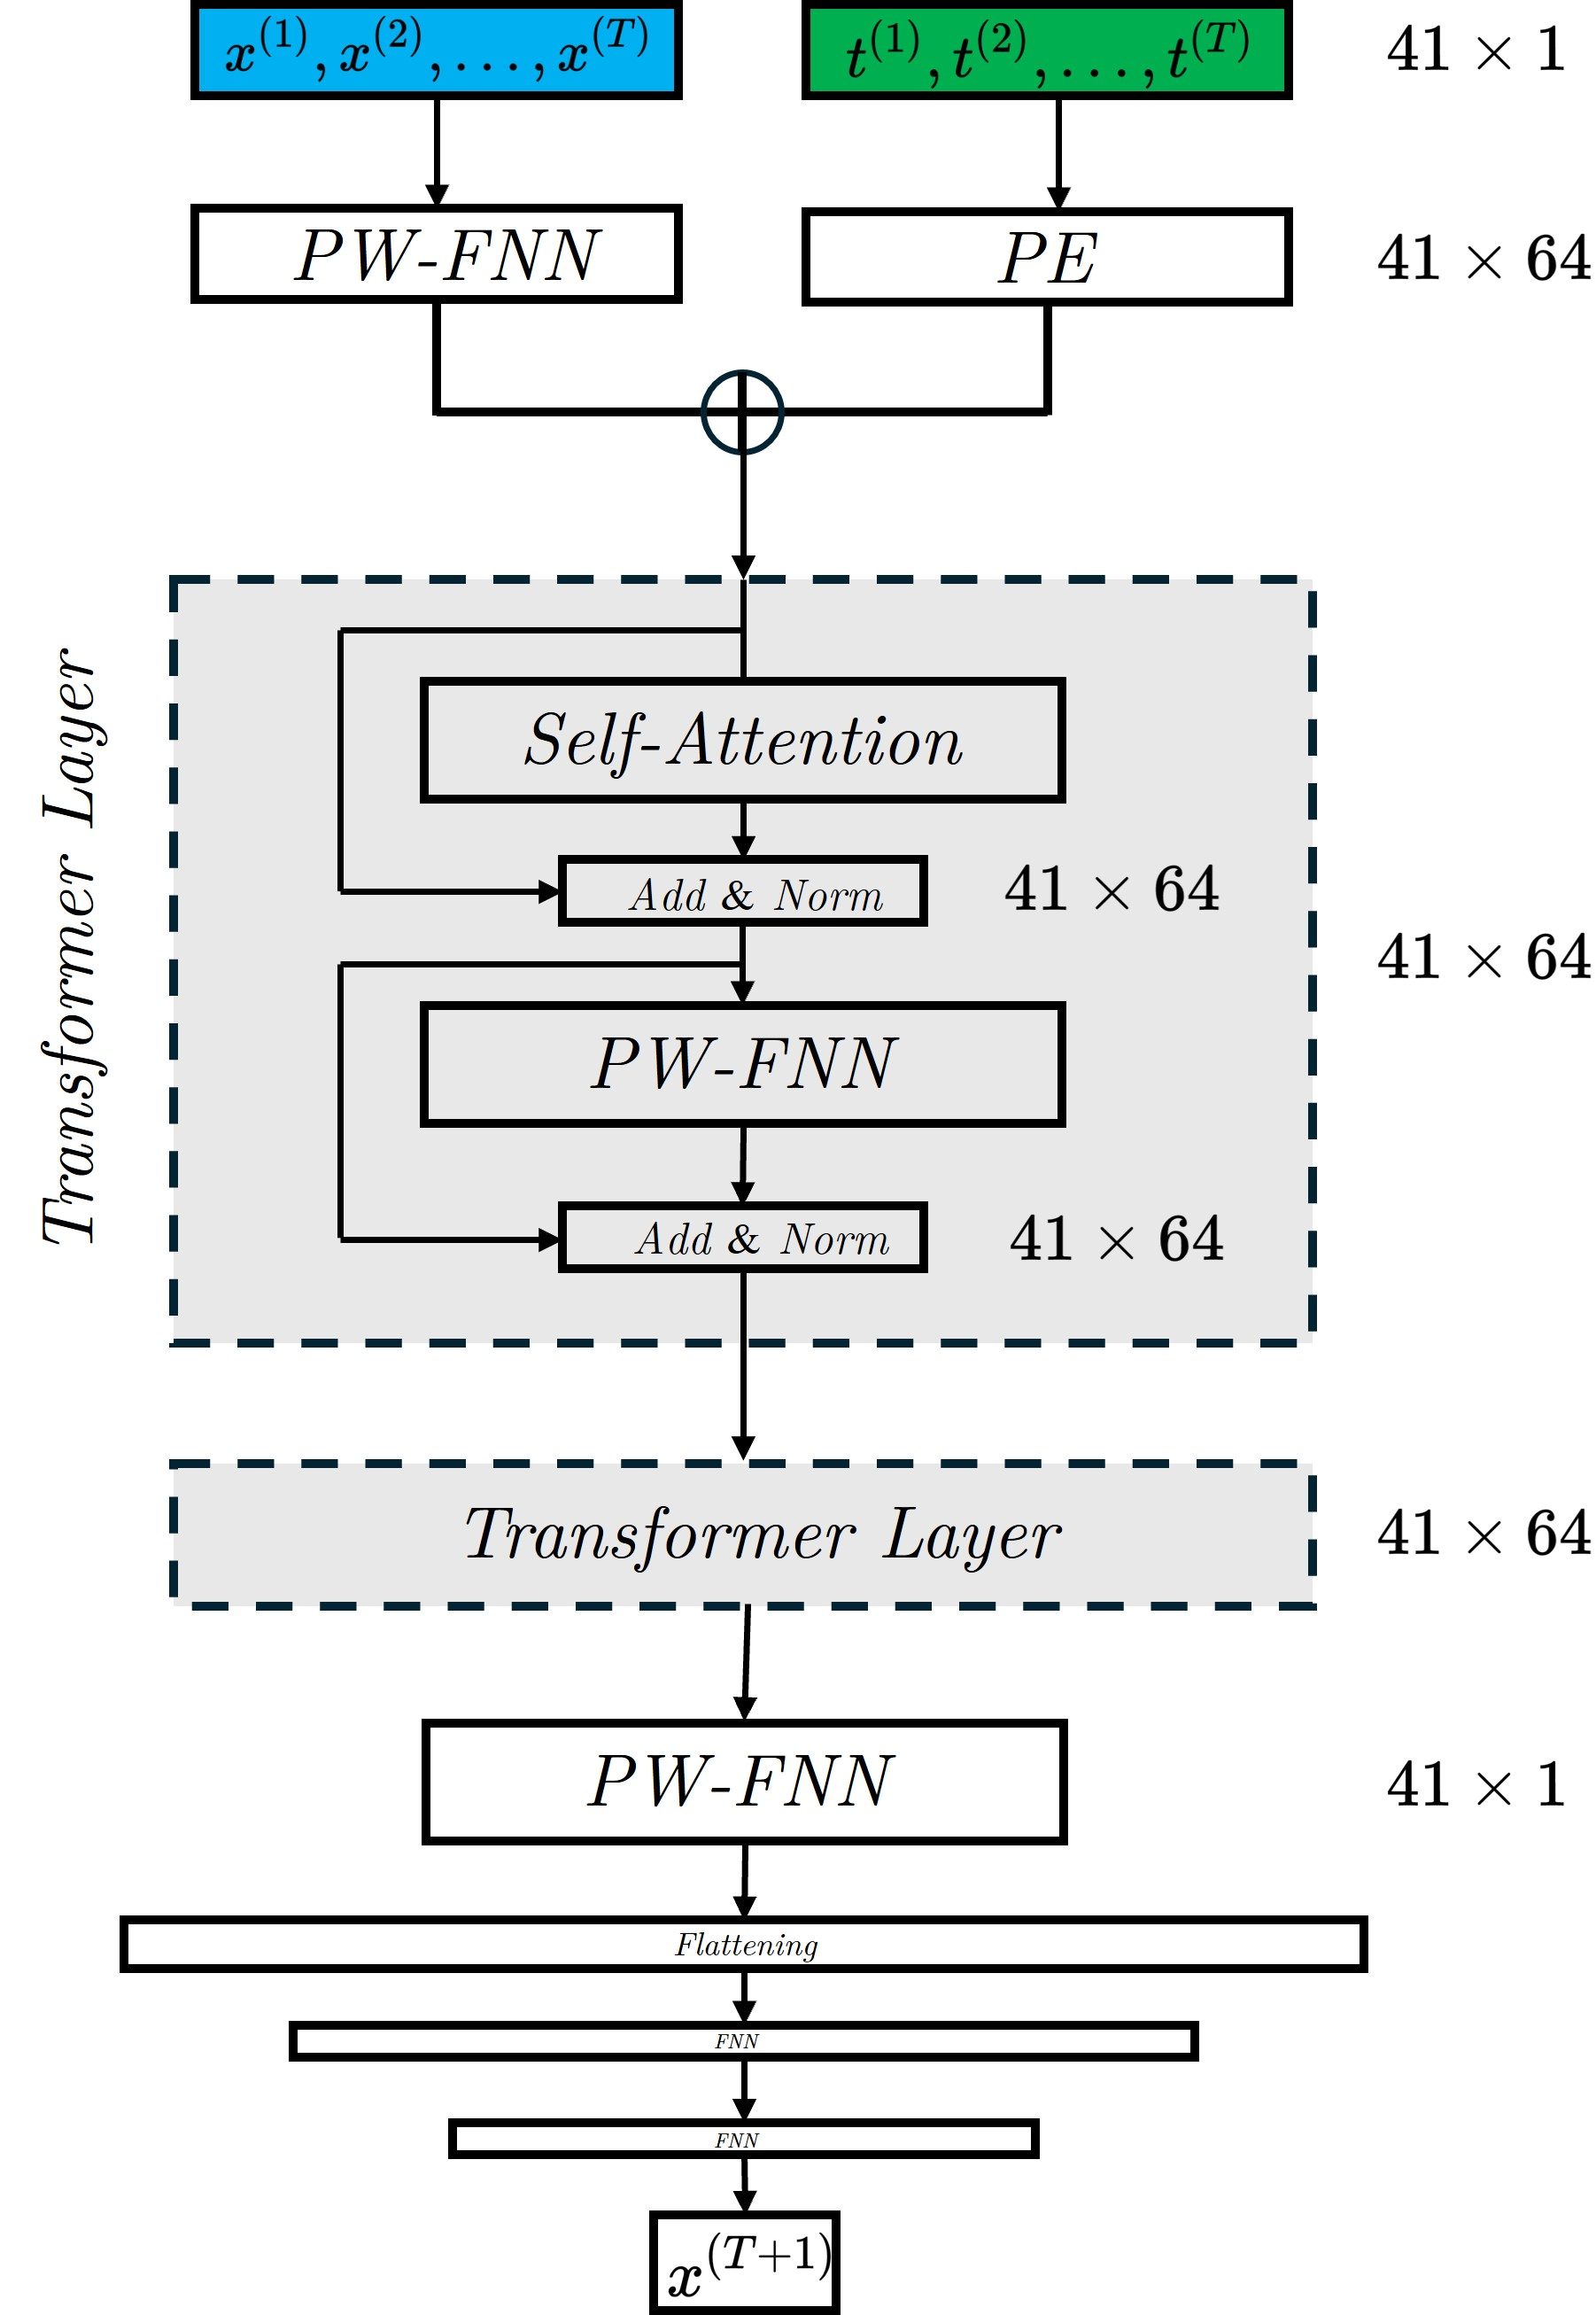


The data set used here is taken from  Frontiers in Physics 11, 1223973 (2023)). The reduced density matrix is calculated for all combinations of the following parameters: $\epsilon / \Delta=\{0,1\}, \lambda / \Delta=\{0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0\}, \quad \omega_c / \Delta=$ $\{1,2,3,4,5,6,7,8,9,10\}$, and $\beta \Delta=\{0.1,0.25,0.5,0.75,1\}$. This model is for the symetrci case $\epsilon /\Delta= 0$



In [91]:
# Convert to dt =0.1 and take the small trajecotry for input
traj = result.e_data["Sz"]
time = result.times
traj = traj[::2]
time = time[::2]
traj_input = np.array(traj[0:41])
time_input = np.array(time[0:41])
print(time_input)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4. ]


In [92]:
# Import the already trained model
model  = tf.keras.models.load_model('checkpoint.modelsym.keras', custom_objects={"MapLayer": MapLayer})
#model.summary()

In [93]:
# Predict using the ML model
memory = 41      #Length of the trajectory
ntimes = 200     # Total on time steps
traj_predicted = np.copy(traj)
for n in range(ntimes-memory):
    traj_input=np.array(traj_predicted[n:n+memory])
    time_input=np.array(time[n:n+memory])
    x0= traj_input.reshape(1,memory)
    x1= time_input.reshape(1,memory)
    #print(x0,x1)
    yhat = model.predict([x0,x1], verbose=False)
    traj_predicted[n+memory]=yhat

In [100]:
# Calculate the error with the reference Trajc 
mse = mean_squared_error(np.real(traj), np.real(traj_predicted))
print("MSE=",mse)

MSE= 9.47157944028073e-07


/home/leherrera/anaconda3/envs/qutip+tf/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/leherrera/anaconda3/envs/qutip+tf/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


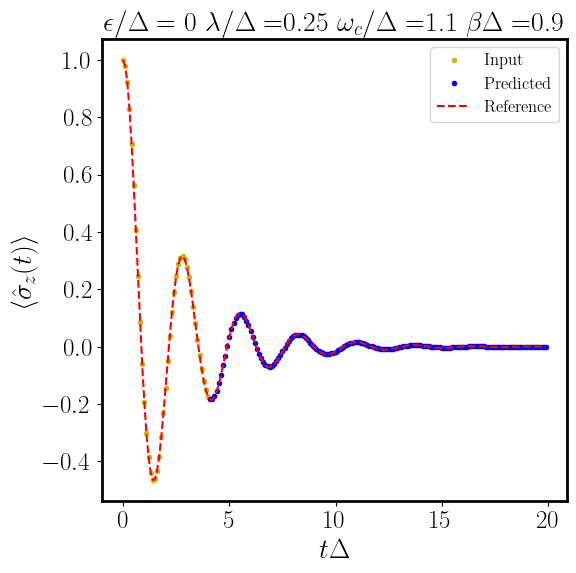

In [117]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6,6))
plt.plot(time[:41],traj_predicted[:41] , "y.", label ="Input" )
plt.plot(time[41:],traj_predicted[41:] , "b.", label ="Predicted" )
plt.plot(time,traj, "r--", label="Reference")
axes.set_ylabel(r' $\langle \hat{\sigma}_z(t) \rangle$', fontsize=20)
axes.set_xlabel(r' $t \Delta$', fontsize=20)
axes.set_title(r' $\epsilon/\Delta= 0$  $\lambda/\Delta=$'+str(lam)+ r'  $\omega_c/\Delta=$'+str(gamma) + r' $\beta \Delta=$'+str(b) ,fontsize=20 )
axes.legend(loc=0, fontsize=12)